In [2]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step_nonlinear, ensrf_steps, kalman_filter_process
from jax_models import visualize_observations, Lorenz63, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

# Parameters
F = 8.0
dt = 0.01
num_steps = 250  # Number of time steps

J0 = 0
n = 3  # Number of state variables
Q = 0.2 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
H = jnp.eye(n)  # Observation matrix

N = 10 # number of MC samples
n_ensemble = 30
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q

l63_model = Lorenz63(dt = dt)
l63_step = Partial(l63_model.step)
state_transition_function = l63_step

jacobian_function = jacrev(l63_step, argnums=0)
jac_func = Partial(jacobian_function)
# Generate true states and observations using the Lorenz '63 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l63_step, observation_interval)

In [3]:
@jit
def sqrtm(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    inv_sqrt_eigenvalues = jnp.sqrt(eigenvalues)
    Lambda_inv_sqrt = jnp.diag(inv_sqrt_eigenvalues)
    M_sqrt = eigenvectors @ Lambda_inv_sqrt @ eigenvectors.T
    return M_sqrt.real
@jit
def ensrf_step(ensemble, y, H, Q, R, localization_matrix, inflation, key):
    n_ensemble = ensemble.shape[1]
    x_m = jnp.mean(ensemble, axis=1)
    raw_A = (ensemble - x_m.reshape((-1, 1))) 
    C_pred = (raw_A @ raw_A.T) / (n_ensemble - 1) + Q
    #C_pred = ledoit_wolf(C_pred, 0.1)
    A = raw_A * inflation
    P = localization_matrix*(A @ A.T) / (n_ensemble - 1) + Q
    K = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
    x_m += K @ (y - H @ x_m)
    M_sqrt = sqrtm(jnp.eye(x_m.shape[0]) - K@H)
    updated_A = M_sqrt @ A
    updated_ensemble = x_m.reshape((-1, 1)) + updated_A
    updated_P = (updated_A @ updated_A.T / (n_ensemble - 1))
    #updated_P = ledoit_wolf(updated_P, 0.1) no shrinkage for L63!
    return ensemble, C_pred, updated_ensemble, updated_P


@partial(jit, static_argnums=(3))
def ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key):
    model_vmap = jax.vmap(lambda v: state_transition_function(v), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=num_steps + 1)
    subkeys = jnp.array(subkeys)

    def inner(carry, t):
        ensemble, covar = carry
        ensemble_predicted = model_vmap(ensemble)
        def true_fun(_):
            x_m, C_pred, ensemble_updated, Pf_updated = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, localization_matrix, inflation, subkeys[t])
            return x_m, C_pred, ensemble_updated, Pf_updated
        def false_fun(_): # will require an update for larger observation intervals
            return ensemble_predicted, covar, ensemble_predicted, covar
        _, C_pred, ensemble_updated, Pf_updated = jax.lax.cond(t % observation_interval == 0, true_fun, false_fun, operand=None)
        return (ensemble_updated, Pf_updated), (ensemble_predicted, C_pred, ensemble_updated, Pf_updated)

    n = len(Q[0])
    covariance_init = jnp.zeros((n, n))
    _, (ensemble_preds, C_preds, ensembles, covariances) = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    return ensemble_preds, C_preds, ensembles, covariances

In [4]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [5]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
    pred_states, pred_covar, states, covariances = ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    pred_mean = jnp.mean(pred_states, axis = -1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(pred_mean, pred_covar, ensemble_mean, covariances, n, state_transition_function, Q, key)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [6]:
base_m, base_C, base_K  = kalman_filter_process(state_transition_function, jac_func, m0, C0, observations, H, Q, R)


In [7]:
from jax_filters import particle_filter
# import jax_filters
# import importlib
# importlib.reload(jax_filters)
num_particles = 2000
estimated_states = particle_filter(key, num_particles, num_steps, initial_state, observations, observation_interval, state_transition_function, H, Q, R)


In [18]:
import pickle
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = jnp.ones((n,n))

inflation_factors = jnp.arange(1.0, 2.05, 0.05)  # Range of inflation factors
results = {}
for inflation in inflation_factors:
    key, subkey = random.split(key)
    pred_states, pred_covariances, states, covariances = ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    results[float(inflation)] = {'states': states, 'covariances': covariances}

# Save results to disk
with open('simulation_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
with open('simulation_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [11]:
def calculate_rmse(ensemble_means, true_states):
    return jnp.sqrt(jnp.mean((ensemble_means - true_states) ** 2))

def calculate_spread_error_ratio(states, true_states):
    ensemble_spread = jnp.mean(jnp.std(states, axis=2))
    rmse = calculate_rmse(jnp.mean(states, axis=2), true_states)
    return ensemble_spread / rmse if rmse != 0 else float('nan')



In [12]:
def calculate_covariance_matrix(states):
    mean = jnp.mean(states, axis=2)
    deviations = states - mean[:, :, jnp.newaxis]
    covariance_matrix = jnp.einsum('ijk,ilk->ijl', deviations, deviations) / (states.shape[2] - 1)
    return covariance_matrix


In [25]:
import numpy as np
mean_diffs = []
covariance_diffs = []
rmses = []

spread_error_ratios = []
KLs = []
KLs_enkf_pf = []

inflation_factors = sorted(results.keys())
pf_means = jnp.mean(estimated_states, axis=2)
pf_covariances = calculate_covariance_matrix(estimated_states)
pf_rmse = calculate_rmse(pf_means, true_states)
pf_spread_error_ratio = calculate_spread_error_ratio(jnp.array(estimated_states), true_states)

for inflation in inflation_factors:
    enkf_data = results[inflation]
    
    # Compute means and covariances
    enkf_means = jnp.mean(jnp.array(enkf_data['states']), axis=2)
    enkf_covariances = calculate_covariance_matrix(jnp.array(enkf_data['states']))
    
    # Time-averaged differences
    mean_diff = jnp.mean(jnp.abs(enkf_means - pf_means))
    covariance_diff = jnp.mean(jnp.linalg.norm(enkf_covariances - pf_covariances, ord='fro', axis=(1, 2)))

    mean_diffs.append(mean_diff)
    covariance_diffs.append(covariance_diff)

  
    rmse = calculate_rmse(enkf_means, true_states)
    spread_error_ratio = calculate_spread_error_ratio(jnp.array(enkf_data['states']), true_states)

    rmses.append(rmse)
    spread_error_ratios.append(spread_error_ratio)

    KLs.append(np.mean([KL_gaussian(n, pf_means[t], pf_covariances[t], enkf_means[t], enkf_covariances[t]) for t in range(enkf_means.shape[0])]))
    KLs_enkf_pf.append(np.mean([KL_gaussian(n, enkf_means[t], enkf_covariances[t], pf_means[t], pf_covariances[t]) for t in range(enkf_means.shape[0])]))


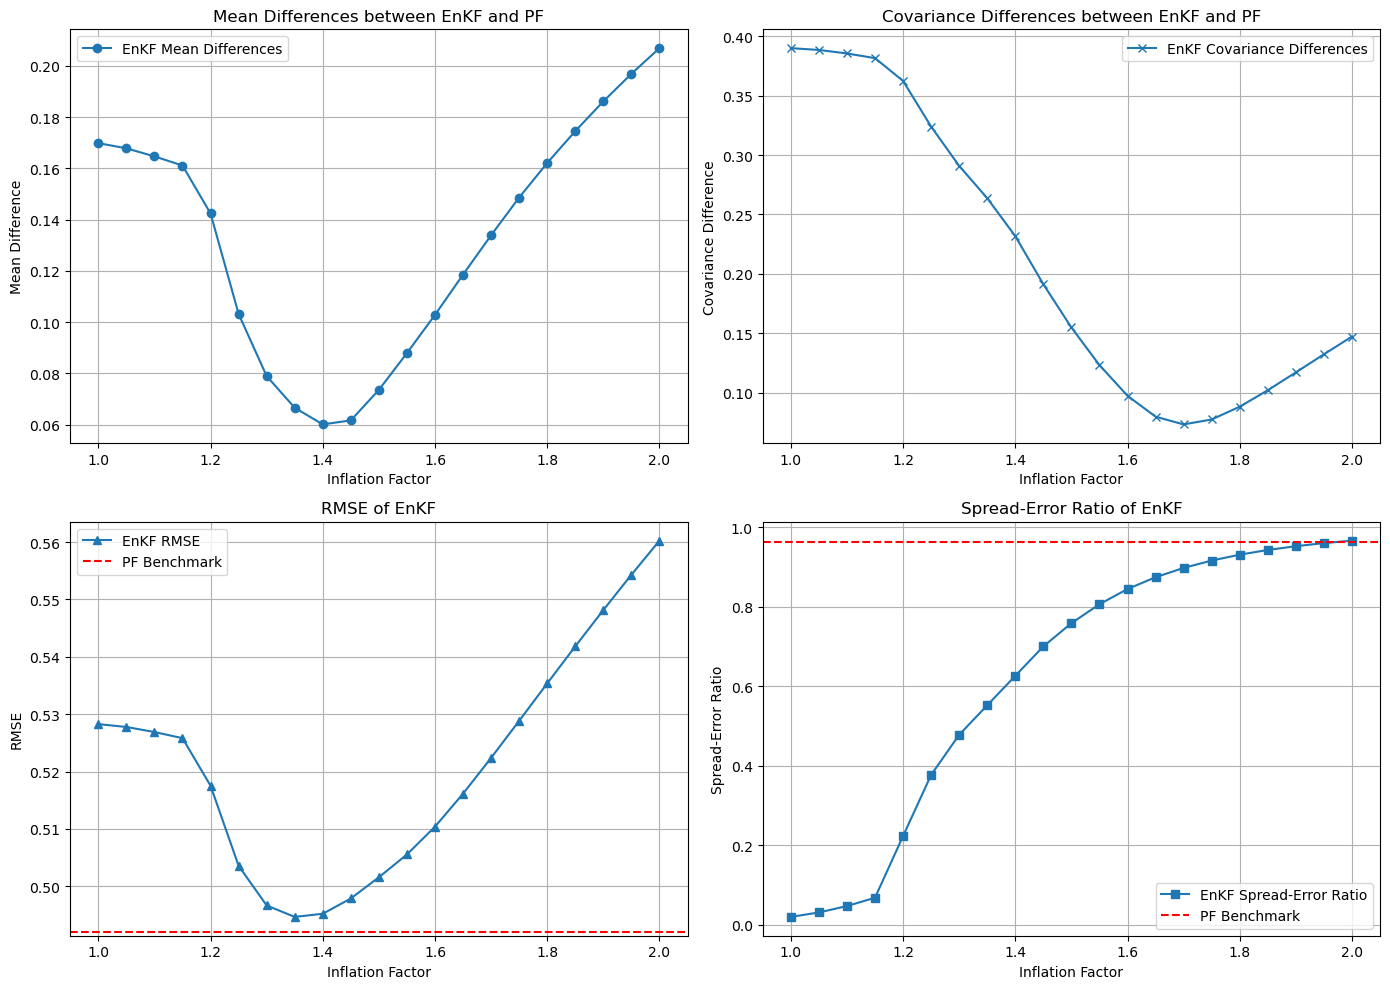

In [27]:
import matplotlib.pyplot as plt
import numpy as np
inflation_factors = sorted(results.keys())
plt.figure(figsize=(14, 10))

# Subplot for Mean Differences
plt.subplot(2, 2, 1)
plt.plot(inflation_factors, mean_diffs, label='EnKF Mean Differences', marker='o')
plt.title('Mean Differences between EnKF and PF')
plt.xlabel('Inflation Factor')
plt.ylabel('Mean Difference')
plt.legend()
plt.grid(True)

# Subplot for Covariance Differences
plt.subplot(2, 2, 2)
plt.plot(inflation_factors, covariance_diffs, label='EnKF Covariance Differences', marker='x')
plt.title('Covariance Differences between EnKF and PF')
plt.xlabel('Inflation Factor')
plt.ylabel('Covariance Difference')
plt.legend()
plt.grid(True)

# Subplot for RMSE
plt.subplot(2, 2, 3)
plt.plot(inflation_factors, rmses, label='EnKF RMSE', marker='^')
plt.axhline(y=pf_rmse, color='r', linestyle='--', label='PF Benchmark')
plt.title('RMSE of EnKF')
plt.xlabel('Inflation Factor')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Subplot for Spread-Error Ratio
plt.subplot(2, 2, 4)
plt.plot(inflation_factors, spread_error_ratios, label='EnKF Spread-Error Ratio', marker='s')
plt.axhline(y=pf_spread_error_ratio, color='r', linestyle='--', label='PF Benchmark')
plt.title('Spread-Error Ratio of EnKF')
plt.xlabel('Inflation Factor')
plt.ylabel('Spread-Error Ratio')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('analysis_results.pdf')

plt.show()


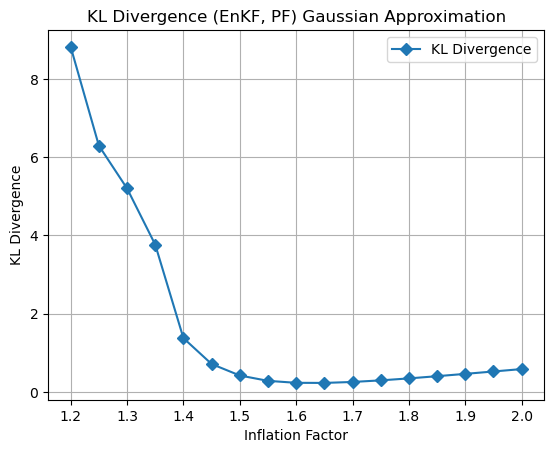

In [28]:
plt.plot(inflation_factors[:], KLs_enkf_pf[:], label='KL Divergence', marker='D')
plt.title('KL Divergence (EnKF, PF) Gaussian Approximation')
plt.xlabel('Inflation Factor')
plt.ylabel('KL Divergence')
plt.legend()
plt.savefig('kl_enkf_pf.pdf')

plt.grid(True)

In [85]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring

var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.45 # Example starting value for inflation
radius = 3
alpha = 1e-5  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 20  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
# localization_matrix = generate_localization_matrix(n, radius) 
localization_matrix = jnp.ones((n,n)) # no localization
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
true_div = []
covars = []
analysis_states = []

n_iters = 200


for i in tqdm(range(n_iters)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    inflations.append(inflation_opt)

    pred_states, pred_covariances, states, covariances = ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    true_div.append(total_kl_divergence / num_steps)
    covars.append(covariances)
    analysis_states.append(states)


import pickle
result_dict = {'crpss': crpss, 'rmses': rmses, 'covars': covars, 'inflations': inflations, 'true_div': true_div, 'analysis_states': analysis_states}
with open('simulation_results.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [79]:
covar_diffs = []
for iter_covars in covars:
    frobenius_norms = jnp.array([jnp.linalg.norm(particle_covars[i] - iter_covars[i], 'fro') for i in range(num_steps)])
    covar_diffs.append(jnp.mean(frobenius_norms))


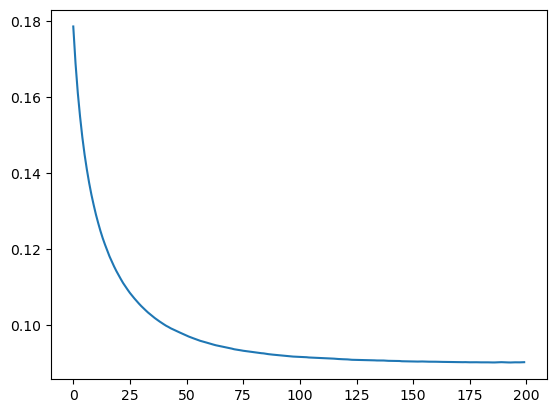

In [80]:
plt.plot(covar_diffs)

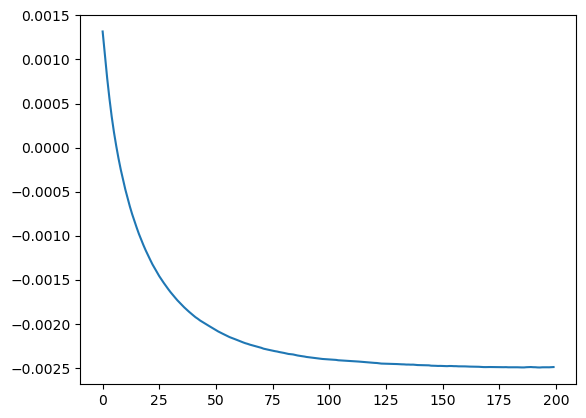

In [81]:
part_mean = jnp.mean(estimated_states, axis=-1)  # Taking the mean across the ensemble members dimension
mean_diffs = []
for analy in analysis_states:
    analy_mean =  jnp.mean(analy, axis=-1) 
    mean_diffs.append(jnp.mean(analy_mean - part_mean))
plt.plot(mean_diffs)

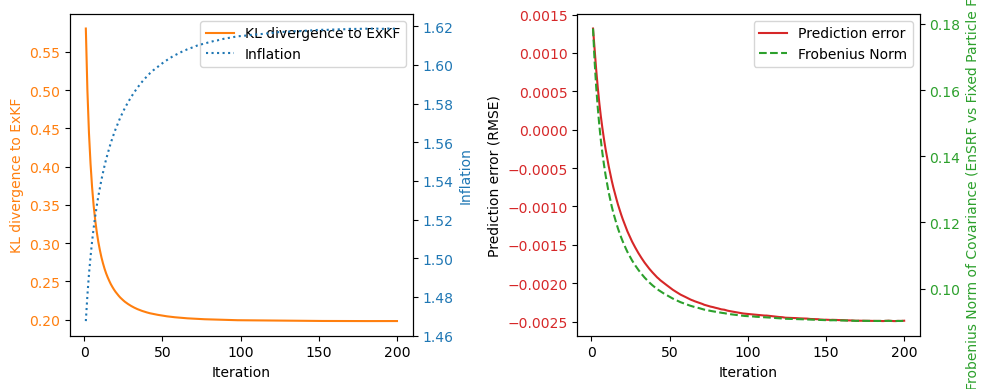

In [84]:
fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

color = 'tab:orange'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('KL divergence to ExKF', color=color)
ln1 = ax1.plot(range(1, n_iters+1), true_div, label='KL divergence to ExKF', color=color, linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(range(1, n_iters+1), inflations, label='Inflation', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

lns = ln1 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

ax3.plot(range(1, n_iters+1), mean_diffs, label='Prediction error', color='tab:red')
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (RMSE)")
ax3.tick_params(axis='y', labelcolor='tab:red')

ax4 = ax3.twinx()
color = 'tab:green'
ax4.set_ylabel('Frobenius Norm of Covariance (EnSRF vs Fixed Particle Filter))', color=color)
ln4 = ax4.plot(range(1, n_iters+1), covar_diffs, label='Frobenius Norm', color=color, linestyle='--')
ax4.tick_params(axis='y', labelcolor=color)

# Combine legends from ax3 and ax4
lns2 = ax3.get_lines() + ax4.get_lines()
labs2 = [l.get_label() for l in lns2]
ax3.legend(lns2, labs2, loc='upper right')

plt.tight_layout()